In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# image panel

In [3]:
f105N = fits.open('/Volumes/Vince_CLEAR/Data/CLEAR/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits')
f105N_img = f105N[0].data

f105S = fits.open('/Volumes/Vince_CLEAR/Data/CLEAR/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits')
f105S_img = f105S[0].data

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

wfN = wcs.WCS(f105N[0].header)
wfS = wcs.WCS(f105S[0].header)

def RS_img(img):
    IMG = np.array(img) + 100

    m = np.percentile(IMG, 5)
    M = np.percentile(IMG, 99)

    IMG -= m
    IMG[IMG <= 0] = 0
    IMG /= (M-m)
    IMG[IMG > 1] =1
    return np.arcsinh(IMG)

def get_positions(ra, dec, D, W):
    [Of, Lf, Hf]=W.wcs_world2pix([[ra ,dec],[ra-D ,dec-D], [ra+D ,dec+D]],1)
    Of = Of.astype(int)
    Lf = Lf.astype(int)
    Hf = Hf.astype(int)
    return Of, Lf, Hf

def img_ext(field, gid):
    D = (1.5 * u.arcsec * (1*u.arcmin/(60*u.arcsec)) * (1*u.deg/(60*u.arcmin))).value

    if field == 'GND':
        ra=v4N.query('id == {}'.format(gid)).ra.values[0]
        dec=v4N.query('id == {}'.format(gid)).dec.values[0]
        W = wfN
    if field == 'GSD':
        ra=v4S.query('id == {}'.format(gid)).ra.values[0]
        dec=v4S.query('id == {}'.format(gid)).dec.values[0]
        W = wfS

    Of1, Lf1, Hf1 = get_positions(ra, dec, D, W)

    dx = np.abs(Of1[0] - Lf1[0])

    if field == 'GND':
        gal_img = f105N_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    if field == 'GSD':
        gal_img = f105S_img[Of1[1] - dx : Of1[1]+1 + dx , Of1[0] - dx: Of1[0]+1 + dx]
    return gal_img

([], <a list of 0 Text yticklabel objects>)

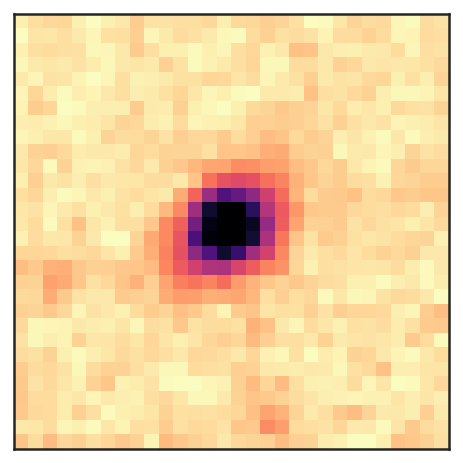

In [20]:
IMG = RS_img(img_ext('GSD',41520))

iIMG = interp2d(np.arange(45),np.arange(45),IMG)(np.linspace(0,44, 30), np.linspace(0,44, 30))

plt.imshow(iIMG, cmap = 'magma_r')
plt.xticks([])
plt.yticks([])

# SFH Panel

In [64]:
import pickle
from spec_tools import Gen_SFH
i=2

# try:
#     lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format( mdb.field[i],  mdb.id[i]))
#     lbt, sfh16 = np.load('../data/SFH/{0}_{1}_16.npy'.format( mdb.field[i],  mdb.id[i]))
#     lbt, sfh84 = np.load('../data/SFH/{0}_{1}_84.npy'.format( mdb.field[i],  mdb.id[i]))

# except:
with open('../data/SFH/{}_{}_1D.pkl'.format( mdb.field[i],  mdb.id[i]), 'rb') as sfh_file:
    sfh = pickle.load(sfh_file)
# lbt = sfh.LBT 
# sfh = sfh.SFH 




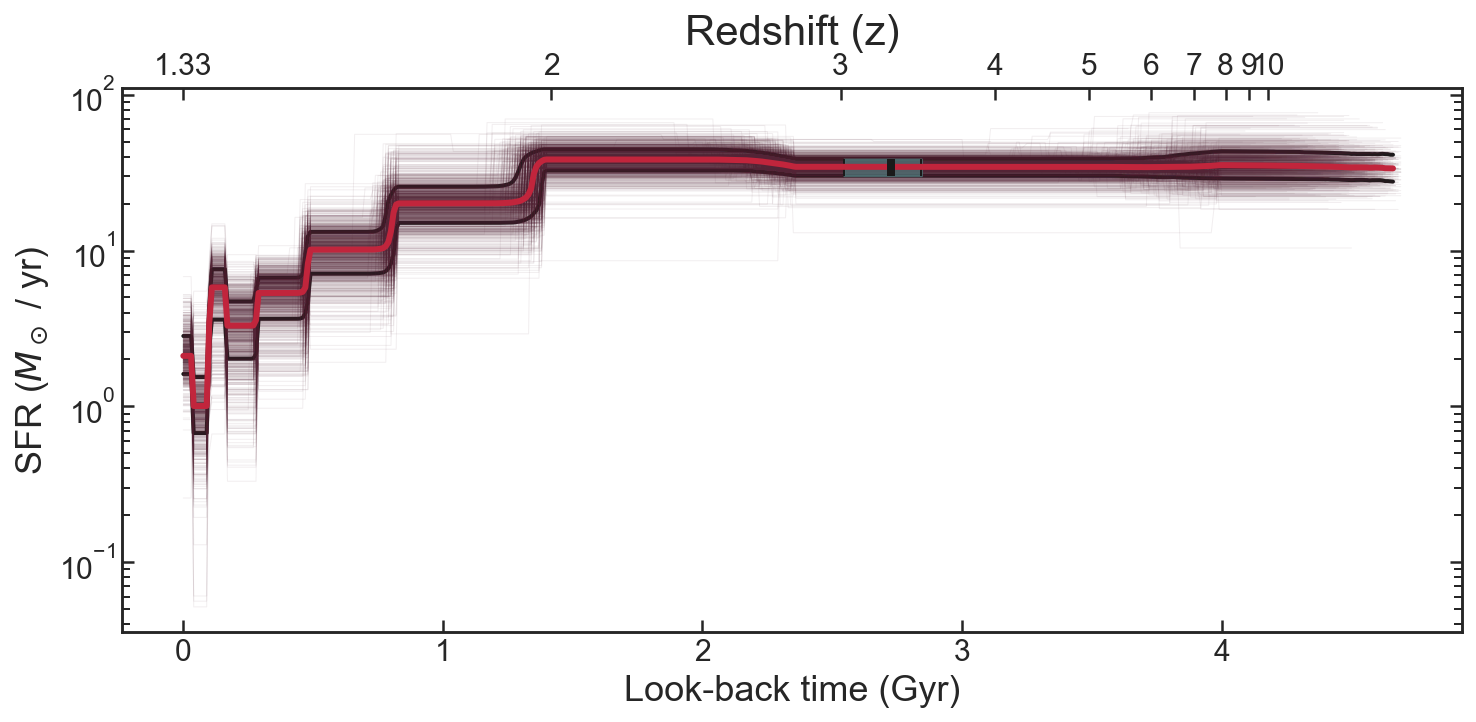

In [94]:
isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

plt.figure(figsize=[12,5])
ax = plt.subplot()
ax.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)
ax.plot(sfh.fulltimes,sfh.sfr_grid[:1000].T, color = '#532436', alpha=.075, linewidth = 0.5)

# ax.vlines(sfh.t_50,isfhl(sfh.t_50), isfhh(sfh.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax.vlines(sfh.t_50,isfhl(sfh.t_50), isfhh(sfh.t_50), color = 'k', linewidth = 4, zorder = 10)

hdr = np.linspace(sfh.t_50_hci[0],sfh.t_50_hci[1])

ax.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
ax.vlines(sfh.t_50_hci[0],isfhl(sfh.t_50_hci[0]),isfhh(sfh.t_50_hci[0]), 
               color = 'k', linewidth = 1, zorder = 8)
ax.vlines(sfh.t_50_hci[1],isfhl(sfh.t_50_hci[1]),isfhh(sfh.t_50_hci[1]), 
               color = 'k', linewidth = 1, zorder = 8)

max_lbt = np.round(sfh.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(mdb.zgrism[2]).value
age_at_z = cosmo.lookback_time(mdb.zgrism[2]).value
zarray = [np.round(mdb.zgrism[2],2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 

tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax2 = ax.twiny()

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(tarray)
ax2.set_xticklabels(zarray)
ax2.xaxis.set_ticks_position('top')

ax.set_xlabel('Look-back time (Gyr)', fontsize=18)
ax.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=18)
ax2.set_xlabel('Redshift (z)', fontsize=21) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.yscale('log')
plt.show()

